In [1]:
!cat /etc/issue.net

Ubuntu 18.04.3 LTS


In [0]:
!nvidia-smi

Tue Nov  5 06:48:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls '/content/drive/'

'My Drive'


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.ToTensor()])

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader('/content/drive/My Drive/picasso.jpg')
content_img = image_loader('/content/drive/My Drive/dancing.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

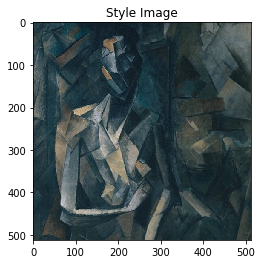

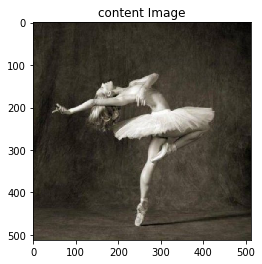

In [7]:
unloader = transforms.ToPILImage()  #reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title = "content Image")



# Loss Functions

### Content Loss

In [0]:
class ContentLoss(nn.Module):

  def __init__(self, target, ):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input



### Style Loss

In [0]:
def gram_matrix(input):
  a, b, c, d = input.size() #a = batch size(=1), b=number of feature maps, (c,d) = dim of a f. map(N = c*d)

  features = input.view(a * b, c * d) # resize F_XL into \hat F_XL

  G = torch.mm(features, features.t())  #compute the gram product

  #normalize the values of gram matrix, by dividing the number of element in each feature maps
  return G.div(a * b * c * d)


In [0]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()  ## stoping tensor history, 업데이트 기록 중지? 

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

### Importing the Model

In [11]:
#pre-trained neural network. VGG19 network
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:23<00:00, 24.5MB/s]


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
     # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization) #layer 추가! 초기세팅 해놓는 느낌! 

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]  #??? 물어볼 것 

    return model, style_losses, content_losses

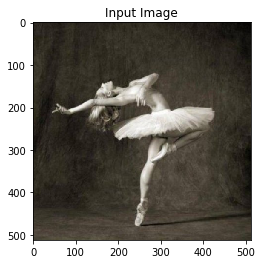

In [14]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title="Input Image")

### Gradient Descent 

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
##function that performs the neural transfer. 
#for each iteration of the networks, it is fed and updated input and computes new losses
#run the backward methods of each loss module to dynamicaly compute their gradients

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)   #매개변수가 갱신된다. 

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 4.177859 Content Loss: 4.257125

run [100]:
Style Loss : 1.124133 Content Loss: 3.046212

run [150]:
Style Loss : 0.712544 Content Loss: 2.658991

run [200]:
Style Loss : 0.478563 Content Loss: 2.503137

run [250]:
Style Loss : 0.346022 Content Loss: 2.412567

run [300]:
Style Loss : 0.264733 Content Loss: 2.360283



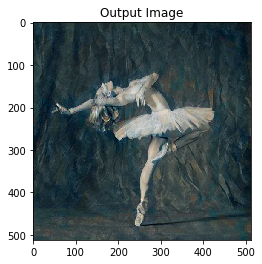

In [17]:
#run the algorithm

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img)

plt.show()
imshow(output, title="Output Image")

plt.ioff()
plt.show()

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 0.059943 Content Loss: 0.194028

run [100]:
Style Loss : 0.078041 Content Loss: 0.039689

run [150]:
Style Loss : 0.081867 Content Loss: 0.013313

run [200]:
Style Loss : 0.081702 Content Loss: 0.008251

run [250]:
Style Loss : 0.081387 Content Loss: 0.005673

run [300]:
Style Loss : 0.081223 Content Loss: 0.004636



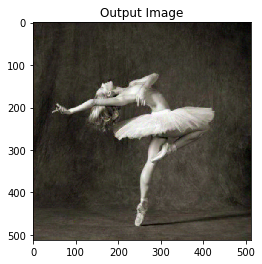

In [18]:
#run the algorithm for beta = 100

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, style_weight=100)

plt.show()
imshow(output, title="Output Image for beta=100")

plt.ioff()
plt.show()

style loss의 비중을 10^6에서 10^2로 바꾸자 원본 이미지와 비슷한 Output Image가 도출되는 것을 확인해 볼 수 있다.   
또한, Content loss가 기존에 비해 무척 작아진다는 것도 주목할 부분이다. 


Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 0.346430 Content Loss: 1.181200

run [100]:
Style Loss : 0.326767 Content Loss: 1.120770

run [150]:
Style Loss : 0.324854 Content Loss: 1.103022

run [200]:
Style Loss : 0.325058 Content Loss: 1.093653

run [250]:
Style Loss : 0.324939 Content Loss: 1.087976

run [300]:
Style Loss : 0.328725 Content Loss: 1.092615



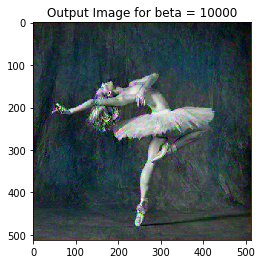

In [20]:
#run the algorithm for beta = 10000

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, style_weight=10000)

plt.show()
imshow(output, title="Output Image for beta = 10000")

plt.ioff()
plt.show()